In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("./data/decision_matrix.csv")
df.set_index("Model", inplace=True)
df

,ROUGE-1,ROUGE-L,BERTScore,Factual_Consistency,Inference_Time,Model_Size
Model,,,,,,
BART-large-CNN,44.2,41.3,0.915,0.89,0.95,1600
PEGASUS-large,45.1,42.2,0.923,0.91,1.15,2200
T5-base,40.3,37.8,0.887,0.85,0.55,850
FLAN-T5-small,38.9,36.5,0.872,0.83,0.40,300
DistilBART-CNN-12-6,42.8,39.9,0.905,0.87,0.60,600


In [11]:

weights = np.array([0.20, 0.15, 0.25, 0.20, 0.10, 0.10])
impacts = np.array(['+', '+', '+', '+', '-', '-'])

In [12]:
norm_matrix = df / np.sqrt((df**2).sum())
norm_matrix

,ROUGE-1,ROUGE-L,BERTScore,Factual_Consistency,Inference_Time,Model_Size
Model,,,,,,
BART-large-CNN,0.467031,0.466447,0.454368,0.457253,0.544191,0.546470
PEGASUS-large,0.476541,0.476612,0.458341,0.467528,0.658758,0.751396
T5-base,0.425823,0.426918,0.440464,0.436702,0.315058,0.290312
FLAN-T5-small,0.411030,0.412235,0.433015,0.426427,0.229133,0.102463
DistilBART-CNN-12-6,0.452239,0.450635,0.449402,0.446977,0.343700,0.204926


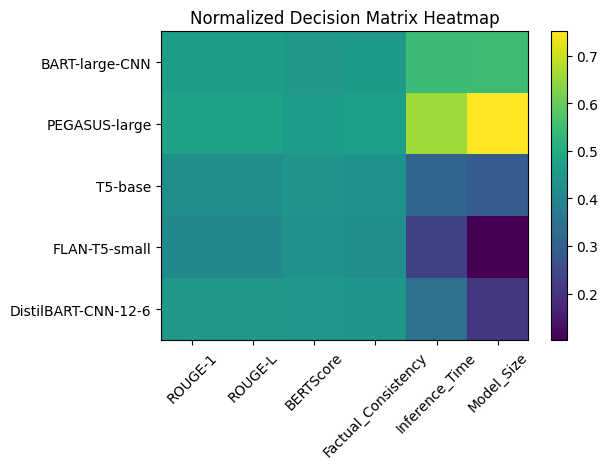

In [13]:
plt.figure()
plt.imshow(norm_matrix, aspect='auto')
plt.colorbar()
plt.xticks(range(len(df.columns)), df.columns, rotation=45)
plt.yticks(range(len(df.index)), df.index)
plt.title("Normalized Decision Matrix Heatmap")
plt.tight_layout()
plt.savefig("./output/normalized_heatmap.png")
plt.show()

In [14]:
weighted_matrix = norm_matrix * weights
weighted_matrix

,ROUGE-1,ROUGE-L,BERTScore,Factual_Consistency,Inference_Time,Model_Size
Model,,,,,,
BART-large-CNN,0.093406,0.069967,0.113592,0.091451,0.054419,0.054647
PEGASUS-large,0.095308,0.071492,0.114585,0.093506,0.065876,0.075140
T5-base,0.085165,0.064038,0.110116,0.087340,0.031506,0.029031
FLAN-T5-small,0.082206,0.061835,0.108254,0.085285,0.022913,0.010246
DistilBART-CNN-12-6,0.090448,0.067595,0.112351,0.089395,0.034370,0.020493


In [15]:
ideal_best = []
ideal_worst = []

for i in range(len(df.columns)):
    if impacts[i] == '+':
        ideal_best.append(weighted_matrix.iloc[:, i].max())
        ideal_worst.append(weighted_matrix.iloc[:, i].min())
    else:
        ideal_best.append(weighted_matrix.iloc[:, i].min())
        ideal_worst.append(weighted_matrix.iloc[:, i].max())

ideal_best = np.array(ideal_best)
ideal_worst = np.array(ideal_worst)


In [16]:
S_plus = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
S_minus = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))

In [17]:
closeness = S_minus / (S_plus + S_minus)

df["Closeness_Score"] = closeness
df["Rank"] = df["Closeness_Score"].rank(ascending=False)

df = df.sort_values(by="Closeness_Score", ascending=False)
df


,ROUGE-1,ROUGE-L,BERTScore,Factual_Consistency,Inference_Time,Model_Size,Closeness_Score,Rank
Model,,,,,,,,
FLAN-T5-small,38.9,36.5,0.872,0.83,0.40,300,0.801271,1.0
DistilBART-CNN-12-6,42.8,39.9,0.905,0.87,0.60,600,0.788229,2.0
T5-base,40.3,37.8,0.887,0.85,0.55,850,0.694653,3.0
BART-large-CNN,44.2,41.3,0.915,0.89,0.95,1600,0.342774,4.0
PEGASUS-large,45.1,42.2,0.923,0.91,1.15,2200,0.198729,5.0


In [18]:
df.to_csv("./results/topsis_scores.csv")

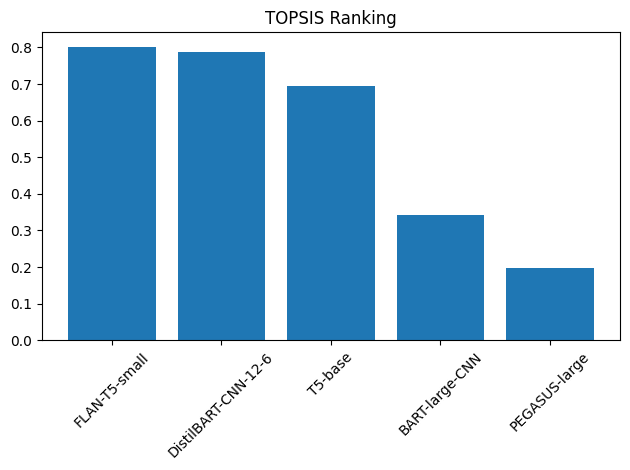

In [20]:
plt.figure()
plt.bar(df.index, df["Closeness_Score"])
plt.xticks(rotation=45)
plt.title("TOPSIS Ranking")
plt.tight_layout()
plt.savefig("./output/closeness_bar_chart.png")
plt.show()

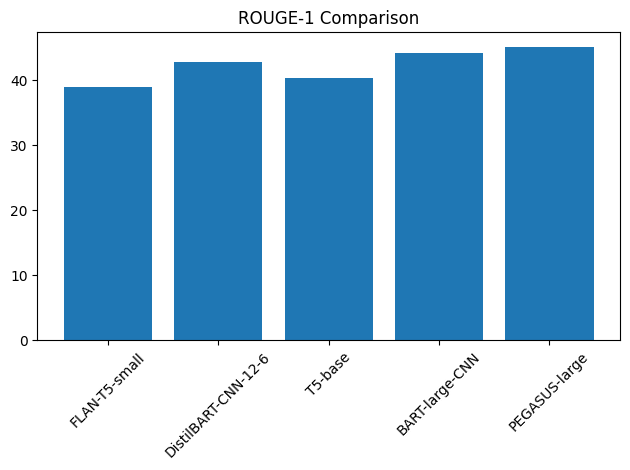

In [22]:
plt.figure()
plt.bar(df.index, df["ROUGE-1"])
plt.xticks(rotation=45)
plt.title("ROUGE-1 Comparison")
plt.tight_layout()
plt.savefig("./output/rouge_comparison.png")
plt.show()

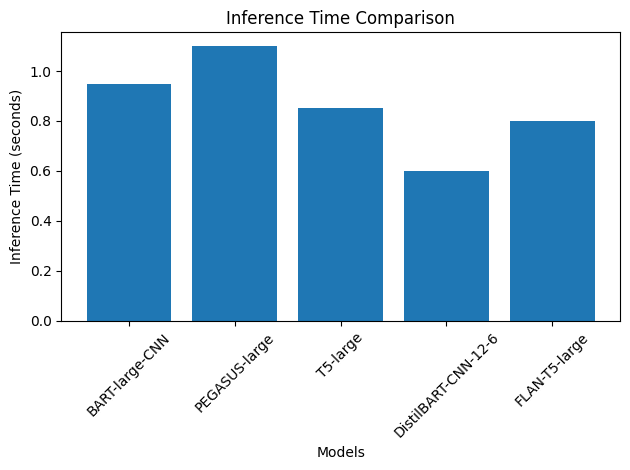

In [14]:
plt.figure()
plt.bar(models, data[:, 4])
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("Inference Time (seconds)")
plt.title("Inference Time Comparison")
plt.tight_layout()
plt.show()

In [15]:
best_model = df.index[0]

print("\n===================================================")
print("Best Model According to TOPSIS:", best_model)
print("===================================================")


Best Model According to TOPSIS: DistilBART-CNN-12-6
